## Notebook 10.3
Bayesian linear regression model fitting. 


In [1]:
# suppress warning messages from pymc3
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# import statistical and plotting packages
import pymc3 as pm
import numpy as np
import pandas as pd
import scipy.stats as ss
import toyplot

## A regression problem


$ \mu = \alpha + \beta_1 X_1  + \beta_2 X_2 + \sigma $

In [19]:
# true params (what we aim to estimate)
nsize = 500
true_Beta1 = 3.0
true_Beta2 = -0.8
true_alpha = 1.1
true_error = 0.8

# predictor variables (measurements on data)
X1 = np.random.normal(20, 10, nsize)
X2 = np.random.normal(10, 5, nsize)
e = np.random.normal(0, true_error, nsize)

# simulated outcome (sampled response data)
u = true_alpha + true_Beta1 * X1 + true_Beta2 * X2 + e

In [20]:
# plot the data
canvas = toyplot.Canvas(width=600, height=250)
ax0 = canvas.cartesian(grid=(1, 2, 0), ylabel="Beta1", xlabel="X1")
ax1 = canvas.cartesian(grid=(1, 2, 1), ylabel="Beta2", xlabel="X2")
ax0.scatterplot(X1, u)
ax1.scatterplot(X2, u);

0 20 40 X1 0 50 100 150 Beta1 <g class="toyplot-Datum" style="fill:rgb(40%,76.1%,64.7%);f

### Set up a Model

In [21]:
with pm.Model() as model:

    # Priors for unknown model parameters
    alpha = pm.Normal('alpha', mu=0, sd=10)
    betas = pm.Normal('betas', mu=0, sd=10, shape=2)
    sigma = pm.HalfNormal('sigma', sd=1)

    # Expected value of outcome
    mu = alpha + betas[0]*X1 + betas[1]*X2

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal('Y_obs', mu=mu, sd=sigma, observed=u)

### Get a maximum a posteriori estimate (MAP) as a starting point
By default this uses the BFGS optimization method from scipy. 

In [22]:
# get maximum likelihood
map_estimate = pm.find_MAP(model=model)
map_estimate

logp = -618.34, ||grad|| = 327.23: 100%|██████████| 49/49 [00:00<00:00, 1773.11it/s]    


{'alpha': array(1.2248145740055192),
 'betas': array([ 2.99775037, -0.80851426]),
 'sigma': array(0.8148394167519807),
 'sigma_log__': array(-0.20476421981529952)}

### Fit model using MCMC sampling from starting point

Here `draws` is the number of samples to keep. There are many additional arguments we could pass to `sample`, which I do not include here, but which can improve the efficiency of the MCMC search. 

In [23]:
with model:
    trace = pm.sample(10000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|█████████▉| 10464/10500 [00:20<00:00, 506.76it/s]/home/deren/miniconda2/envs/Py36/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:451: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.880005275298, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
100%|██████████| 10500/10500 [00:20<00:00, 506.90it/s]


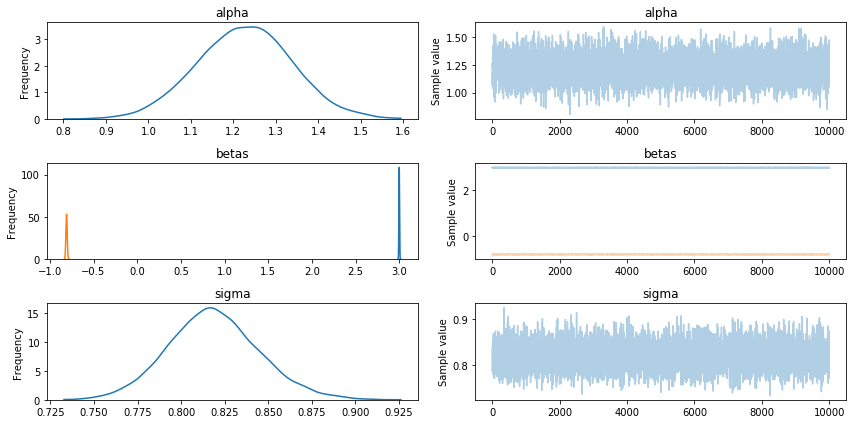

In [24]:
pm.traceplot(trace);

### Estimated parameters posteriors 
The estimated posterior distributions are very accurate for all but the intercept (alpha), which includes the correct value in its 95% HPD interval, but is off by a little bit. Larger sample size or longer MCMC chain may improve estimation. 


In [25]:
pm.summary(trace)


alpha:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  1.225            0.111            0.001            [0.998, 1.435]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  1.006          1.149          1.226          1.299          1.444


betas:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  2.998            0.004            0.000            [2.991, 3.005]
  -0.808           0.007            0.000            [-0.824, -0.795]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  2.990          2.995          2.998          3.000          3.005
  -0.823         -0.814         -0.80